In [36]:
import pandas as pd
import numpy as np

# --- Load Data ---
match_file = "/Users/user/Event-data/Women/WEURO 2025/Norway 1-2 Italy.csv"
mapping_file = "/Users/user/opta-events.csv"
qualifier_file = "/Users/user/opta-qualifiers.csv"

# Read data
df = pd.read_csv(match_file)
event_mapping_df = pd.read_csv(mapping_file, encoding="ISO-8859-1")
qualifiers_df = pd.read_csv(qualifier_file, encoding="ISO-8859-1")

# Merge event names
event_mapping_df.columns = ["typeId", "Event Type", "Description"]
event_mapping_df["typeId"] = pd.to_numeric(event_mapping_df["typeId"], errors="coerce")
df_merged = df.merge(event_mapping_df[["typeId", "Event Type"]], on="typeId", how="left")
df_merged["Event Type"] = df_merged["Event Type"].str.strip()

# Define custom g+ values
custom_event_gplus = {
    1: {1: 0.01, 0: 0.0},
    3: {1: 0.03, 0: -0.02},
    4: {1: -0.02},
    7: {1: 0.03, 0: 0.0},
    8: {1: 0.02, 0: 0.0},
    12: {1: 0.04},
    13: {1: 0.0, 0: 0.0},
    14: {1: 0.10, 0: 0.10},
    15: {1: 0.10, 0: 0.10},
    16: {1: 0.25, 0: 0.25},
    44: {1: 0.02, 0: -0.02},
    49: {1: 0.02},
    50: {1: -0.03},
    51: {1: -0.15},
}

# Qualifier-based rules
qualifier_cols = [col for col in df_merged.columns if col.endswith("/qualifierId")]
value_cols = [col.replace("qualifierId", "value") for col in qualifier_cols]

# Compute g+ per row
def compute_gplus(row):
    tid = row["typeId"]
    out = row["outcome"]
    base = 0.0

    # Event-based base value
    if tid == 1:
        if any(row[col] == 2 for col in qualifier_cols):  # Cross
            base += 0.05 if out == 1 else -0.05
        elif any(row[col] == 196 for col in qualifier_cols) and out == 1:
            base += 0.03
        elif any(row[col] == 4 for col in qualifier_cols) and out == 1:
            base += 0.03

        # Check for progressive/forward/backward/lateral
        try:
            x_end = float(row.get("qualifier/140/value", np.nan))
            x_start = float(row.get("x", np.nan))
            if not np.isnan(x_start) and not np.isnan(x_end):
                dx = x_end - x_start
                if dx >= 12.5:
                    base += 0.06
                elif dx > 0:
                    base += 0.03
                elif dx < 0:
                    base -= 0.02
                elif abs(dx) < 1.0:
                    base += 0.02
        except:
            pass

    if any(row[col] == 210 for col in qualifier_cols):
        base += 0.05
        if row["typeId"] == 16:
            base += 0.05  # assist leads to goal

    # Clearance
    if tid == 12:
        base += 0.04

    # Standard lookup value
    if tid in custom_event_gplus:
        base += custom_event_gplus[tid].get(out, 0.0)

    return round(base, 4)

df_merged["Custom g+"] = df_merged.apply(compute_gplus, axis=1)

# Aggregate by player
player_totals = df_merged.groupby("playerName")["Custom g+"].sum().reset_index()
player_totals = player_totals.dropna(subset=["playerName"])
player_totals.rename(columns={"Custom g+": "g+ Total (Raw)"}, inplace=True)

# Z-score rating (mean=50)
mean = player_totals["g+ Total (Raw)"].mean()
std = player_totals["g+ Total (Raw)"].std()
spread = 10

def z_score_rating(x):
    if std == 0:
        return 50
    z = (x - mean) / std
    return round(50 + z * spread, 2)

player_totals["g+ Z-Score Rating"] = player_totals["g+ Total (Raw)"].apply(z_score_rating)
player_totals["g+ Total (Raw)"] = player_totals["g+ Total (Raw)"].round(3)
player_totals = player_totals.sort_values(by="g+ Z-Score Rating", ascending=False)

# Save to Excel
output_path = "/Users/user/player_gplus_zscore_ratings.xlsx"
player_totals.to_excel(output_path, index=False)

print("✅ Excel file saved at:", output_path)

✅ Excel file saved at: /Users/user/player_gplus_zscore_ratings.xlsx


In [1]:
import pandas as pd
import numpy as np
import os

# --- File Paths ---
match_folder = "/Users/user/Event-data/Men/Norway 2025"
mapping_file = "/Users/user/opta-events.csv"
qualifier_file = "/Users/user/opta-qualifiers.csv"
team_mapping_file = "/Users/user/Downloads/Norway 2025 Matches.csv"
output_folder = "/Users/user/Norway gplys"
os.makedirs(output_folder, exist_ok=True)

# --- Load Mapping Data ---
event_mapping_df = pd.read_csv(mapping_file, encoding="ISO-8859-1")
qualifiers_df = pd.read_csv(qualifier_file, encoding="ISO-8859-1")
team_mapping_df = pd.read_csv(team_mapping_file)

# Clean event mapping
event_mapping_df.columns = ["typeId", "Event Type", "Description"]
event_mapping_df["typeId"] = pd.to_numeric(event_mapping_df["typeId"], errors="coerce")

# Build contestantId → shortName mapping using only contestant 1
team_map = team_mapping_df[["matchInfo/contestant/1/id", "matchInfo/contestant/1/shortName"]].drop_duplicates()
team_map.columns = ["contestantId", "Team"]

# --- Custom g+ Mapping ---
custom_event_gplus = {
    1: {1: 0.01, 0: 0.0},
    3: {1: 0.03, 0: -0.02},
    4: {1: -0.02},
    7: {1: 0.03, 0: 0.0},
    8: {1: 0.02, 0: 0.0},
    12: {1: 0.04},
    13: {1: 0.0, 0: 0.0},
    14: {1: 0.10, 0: 0.10},
    15: {1: 0.10, 0: 0.10},
    16: {1: 0.25, 0: 0.25},
    44: {1: 0.02, 0: -0.02},
    49: {1: 0.02},
    50: {1: -0.03},
    51: {1: -0.15},
}

# --- g+ Calculator Function ---
def compute_gplus(row):
    tid = row["typeId"]
    out = row["outcome"]
    base = 0.0
    if tid == 1:
        if any(row[col] == 2 for col in qualifier_cols):
            base += 0.05 if out == 1 else -0.05
        elif any(row[col] == 196 for col in qualifier_cols) and out == 1:
            base += 0.03
        elif any(row[col] == 4 for col in qualifier_cols) and out == 1:
            base += 0.03
        try:
            x_end = float(row.get("qualifier/140/value", np.nan))
            x_start = float(row.get("x", np.nan))
            if not np.isnan(x_start) and not np.isnan(x_end):
                dx = x_end - x_start
                if dx >= 12.5:
                    base += 0.06
                elif dx > 0:
                    base += 0.03
                elif dx < 0:
                    base -= 0.02
                elif abs(dx) < 1.0:
                    base += 0.02
        except:
            pass
    if any(row[col] == 210 for col in qualifier_cols):
        base += 0.05
        if tid == 16:
            base += 0.05
    if tid == 12:
        base += 0.04
    if tid in custom_event_gplus:
        base += custom_event_gplus[tid].get(out, 0.0)
    return round(base, 4)

# --- Cumulative Results ---
cumulative_df = []

# --- Process All Matches ---
for filename in os.listdir(match_folder):
    if not filename.endswith(".csv") or "Matches" in filename:
        continue
    filepath = os.path.join(match_folder, filename)
    df = pd.read_csv(filepath)

    # Merge event type
    df_merged = df.merge(event_mapping_df[["typeId", "Event Type"]], on="typeId", how="left")
    df_merged["Event Type"] = df_merged["Event Type"].str.strip()

    # Identify qualifier columns
    qualifier_cols = [col for col in df_merged.columns if col.endswith("/qualifierId")]

    # Compute g+
    df_merged["Custom g+"] = df_merged.apply(compute_gplus, axis=1)

    # Merge team name using contestantId
    df_merged = df_merged.merge(team_map, on="contestantId", how="left")

    # Summarize by player
    player_match = df_merged.groupby(["playerName", "Team"])["Custom g+"].sum().reset_index()
    player_match = player_match.dropna(subset=["playerName"])
    player_match["Match"] = filename.replace(".csv", "")
    player_match.rename(columns={"Custom g+": "g+ Total (Raw)"}, inplace=True)

    # Z-score rating
    mean = player_match["g+ Total (Raw)"].mean()
    std = player_match["g+ Total (Raw)"].std()
    spread = 10

    def z_score_rating(x):
        if std == 0:
            return 50
        return round(50 + ((x - mean) / std) * spread, 2)

    player_match["g+ Z-Score Rating"] = player_match["g+ Total (Raw)"].apply(z_score_rating)
    player_match["g+ Total (Raw)"] = player_match["g+ Total (Raw)"].round(3)
    player_match = player_match.sort_values(by="g+ Z-Score Rating", ascending=False)

    # Save per-match Excel
    match_outfile = os.path.join(output_folder, f"{player_match['Match'].iloc[0]}_ratings.xlsx")
    player_match.to_excel(match_outfile, index=False)
    print("✅ Saved:", match_outfile)

    cumulative_df.append(player_match)

# --- Save Cumulative Excel ---
if cumulative_df:
    full_df = pd.concat(cumulative_df, ignore_index=True)
    full_output = os.path.join(output_folder, "WEURO_2025_All_Player_Ratings.xlsx")
    full_df.to_excel(full_output, index=False)
    print("🎯 Cumulative file saved at:", full_output)


✅ Saved: /Users/user/Norway gplys/Strømsgodset 1-2 Brann_ratings.xlsx
✅ Saved: /Users/user/Norway gplys/Molde 0-1 Kristiansund_ratings.xlsx
✅ Saved: /Users/user/Norway gplys/Viking 2-4 Bodø-Glimt_ratings.xlsx
✅ Saved: /Users/user/Norway gplys/Strømsgodset 0-2 Vålerenga_ratings.xlsx
✅ Saved: /Users/user/Norway gplys/Viking 3-0 Fredrikstad_ratings.xlsx
✅ Saved: /Users/user/Norway gplys/Viking 3-1 KFUM_ratings.xlsx
✅ Saved: /Users/user/Norway gplys/Viking 5-1 Haugesund_ratings.xlsx
✅ Saved: /Users/user/Norway gplys/Bodø-Glimt 2-0 Sandefjord_ratings.xlsx
✅ Saved: /Users/user/Norway gplys/Brann 3-1 Viking_ratings.xlsx
✅ Saved: /Users/user/Norway gplys/HamKam 2-5 Viking_ratings.xlsx
✅ Saved: /Users/user/Norway gplys/Rosenborg 3-0 Bryne_ratings.xlsx
✅ Saved: /Users/user/Norway gplys/Vålerenga 3-0 Haugesund_ratings.xlsx
✅ Saved: /Users/user/Norway gplys/KFUM 0-1 Vålerenga_ratings.xlsx
✅ Saved: /Users/user/Norway gplys/Sandefjord 4-0 Haugesund_ratings.xlsx
✅ Saved: /Users/user/Norway gplys/Sarp

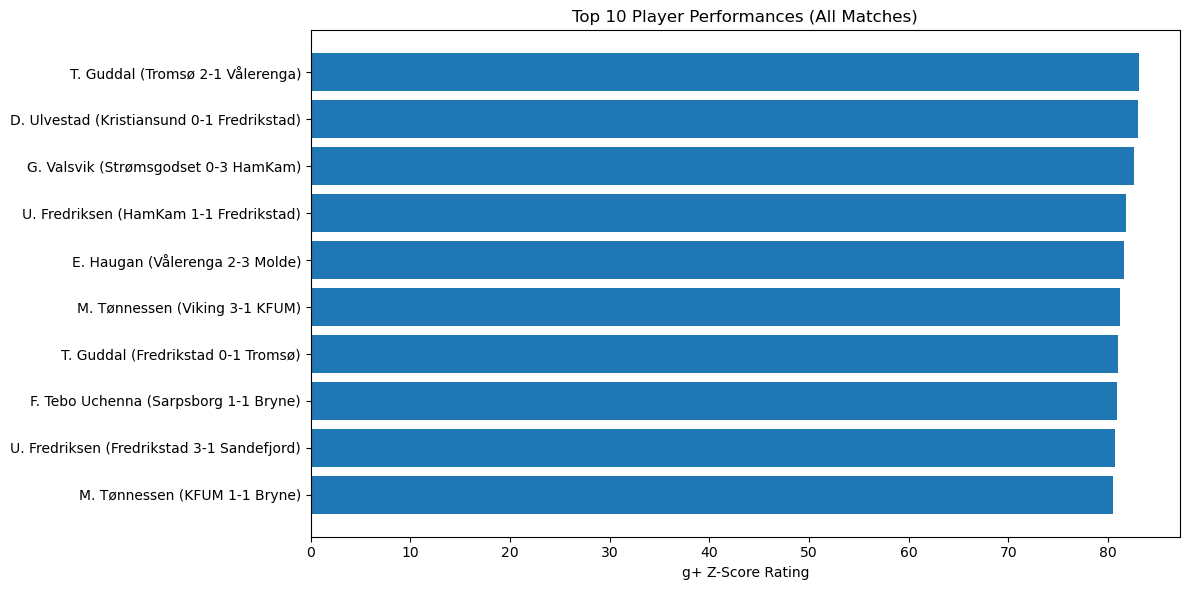

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Path to the cumulative player ratings file
file_path = "/Users/user/Norway gplys/WEURO_2025_All_Player_Ratings.xlsx"

# Load data
df = pd.read_excel(file_path)

# Sort and get top 10 player performances across all matches
top_10 = df.sort_values(by="g+ Z-Score Rating", ascending=False).head(10)

# Create a label for each bar: Player Name (Match)
top_10["Label"] = top_10["playerName"] + " (" + top_10["Match"] + ")"

# Plot
plt.figure(figsize=(12, 6))
plt.barh(top_10["Label"], top_10["g+ Z-Score Rating"])
plt.xlabel("g+ Z-Score Rating")
plt.title("Top 10 Player Performances (All Matches)")
plt.gca().invert_yaxis()  # So highest rating appears at the top
plt.tight_layout()
plt.show()


/opt/anaconda3/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 87.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


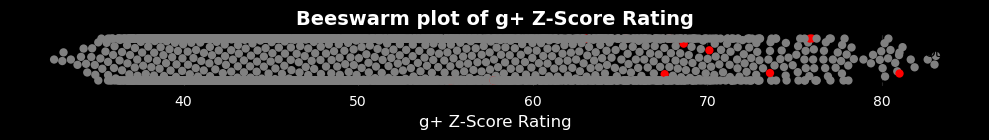

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Parameters
file_path = "/Users/user/Norway gplys/WEURO_2025_All_Player_Ratings.xlsx"
player_name = "T. Nemčík"
metric_column = "g+ Z-Score Rating"

# Load the Excel file
df = pd.read_excel(file_path)

# Drop rows without the metric
df = df.dropna(subset=[metric_column])

# Create a column to flag the target player
df["highlight"] = df["playerName"].apply(lambda x: "Target" if x == player_name else "Other")

# Plot
plt.figure(figsize=(10, 1.5))
sns.swarmplot(data=df, x=metric_column, hue="highlight", palette={"Target": "red", "Other": "gray"}, size=6)

# Styling
plt.title(f"Beeswarm plot of {metric_column}", fontsize=14, color="white", weight='bold')
plt.xlabel(metric_column, fontsize=12, color="white")
plt.ylabel("")
plt.legend(title="", loc="upper right", frameon=False)
plt.gca().set_facecolor("black")
plt.gcf().set_facecolor("black")
plt.xticks(color="white")
plt.yticks([])
plt.grid(axis='x', linestyle='--', color='gray', alpha=0.3)

# Save or show
plt.tight_layout()
plt.savefig("/Users/user/Downloads/gplus_zscore_beeswarm.png", dpi=300, facecolor='black')
plt.show()


In [44]:
import pandas as pd

# Load CSV file
csv_path = "/Users/user/Event-data/Women/WEURO 2025/Norway 1-2 Italy.csv"
df = pd.read_csv(csv_path)
df_merged = df.copy()

# Extract qualifier values row-by-row
def extract_qualifier_value(row, target_qid):
    for i in range(50):
        qid_col = f"qualifier/{i}/qualifierId"
        val_col = f"qualifier/{i}/value"
        if qid_col in row and val_col in row:
            if row[qid_col] == target_qid:
                return row[val_col]
    return None

# Apply extraction
df_merged["qualifier_30_value"] = df.apply(lambda r: extract_qualifier_value(r, 30), axis=1)
df_merged["qualifier_59_value"] = df.apply(lambda r: extract_qualifier_value(r, 59), axis=1)
df_merged["qualifier_230_value"] = df.apply(lambda r: extract_qualifier_value(r, 130), axis=1)

# Updated Formation Lookup Table
formation_lookup = {
    '2': '4-4-2',
    '3': '4-1-2-1-2',
    '4': '4-3-3',
    '5': '4-5-1',
    '6': '4-4-1-1',
    '7': '4-1-4-1',
    '8': '4-2-3-1',
    '9': '4-3-2-1',
    '10': '5-3-2',
    '11': '5-4-1',
    '12': '3-5-2',
    '13': '3-4-3',
    '14': '3-1-3-1-2',
    '15': '4-2-2-2',
    '16': '3-5-1-1',
    '17': '3-4-2-1',
    '18': '3-4-1-2',
    '19': '3-1-4-2',
    '20': '3-4-3',
    '21': '4-1-3-2',
    '22': '4-2-4-0',
    '23': '4-3-1-2'
}
df_merged["Formation Name"] = df_merged["qualifier_230_value"].map(formation_lookup)


# Extract change log of formations by contestant and time
formation_changes = df_merged.dropna(subset=["qualifier_230_value"])
formation_changes = formation_changes[["contestantId", "timeMin", "timeSec", "qualifier_230_value", "Formation Name"]].drop_duplicates()
formation_changes = formation_changes.sort_values(by=["contestantId", "timeMin", "timeSec"])

# Print or export the formation changes
print("\nFormation changes by team and time:")
print(formation_changes)

# Optional: export to Excel
output_path = "/Users/user/formation_changes_by_team.xlsx"
with pd.ExcelWriter(output_path) as writer:
    formation_changes.to_excel(writer, sheet_name="Formation Changes", index=False)

print("\n✅ Exported formation changes to", output_path)



Formation changes by team and time:
                   contestantId  timeMin  timeSec qualifier_230_value  \
1     3am1t05nqol6kzj4jknzk0skn        0        0                   4   
1101  3am1t05nqol6kzj4jknzk0skn       63       47                   8   
0     c072llfz8v0kxjb0y9243dftx        0        0                   4   
1303  c072llfz8v0kxjb0y9243dftx       76       17                   5   
1504  c072llfz8v0kxjb0y9243dftx       91       52                  11   

     Formation Name  
1             4-3-3  
1101        4-2-3-1  
0             4-3-3  
1303          4-5-1  
1504          5-4-1  

✅ Exported formation changes to /Users/user/formation_changes_by_team.xlsx
